Implement the function stubs in altproj_code.py and complete lines with "###"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import rand, randn
from scipy.linalg import inv, svd
from scipy.optimize import linprog
from tqdm import tqdm_notebook as tqdm

#from altproj_code import null_space, altproj, lp_altproj, kaczmarz

### Exercise 1
(10 pts program + 5 pts solution)
Let $U$ and $W$ be subspaces of $\mathbb{R}^5$ that are spanned, respectively, by the columns of the matrices $A$ and $B$ (shown below). 
Write a function `altproj(A,B,v0,n)` that returns $\underline{v}_{2n}$ after $2n$ steps of alternating projection onto $U$ and $W$ starting from $\underline{v}_0$. 
Use this function to find the orthogonal projection of $\underline{v}_0$ (shown below) onto $ U \cap W $. How large should $n$ be chosen so that the projection is correct to 4 decimal places (e.g., absolute error at most 0.0001 in each coordinate)?
$$
A = 
\begin{bmatrix}
 3 & 2 & 3 \\ 1 & 5 & 7 \\ 4 & 11 & 13 \\ 1 & 17 & 19 \\ 5 & 23 & 29
\end{bmatrix}, \qquad
B = 
\begin{bmatrix}
 1 & 1 & 2.5 \\ 2 & 0 & 6 \\ 2 & 1 & 12 \\ 2 & 0 & 18 \\ 6 & -3 & 26
\end{bmatrix}, \qquad
\underline{v}_0 =
\begin{bmatrix}
 1 \\2 \\ 3 \\ 4 \\ 5
\end{bmatrix}
$$
To find the intersection of $U$ and $W$, we note that the following Python snippet returns a matrix whose columns span $ U \cap W $
```
basis_UintW = np.hstack([A, B]) @ null_space(np.hstack([A, -B])) 
```

altproj Example 1 err:
 [2.02213468e-01 1.12923749e-01 6.30609488e-02 3.52156503e-02
 1.96657686e-02 1.09821188e-02 6.13283595e-03 3.42481060e-03
 1.91254548e-03 1.06803868e-03 5.96433727e-04 3.33071448e-04
 1.85999860e-04 1.03869449e-04 5.80046807e-05 3.23920364e-05
 1.80889544e-05 1.01015653e-05 5.64110112e-06 3.15020701e-06]
altproj Example 1:v
 [0.52442269 1.26461352 2.55925049 3.85388314 5.52001383] 



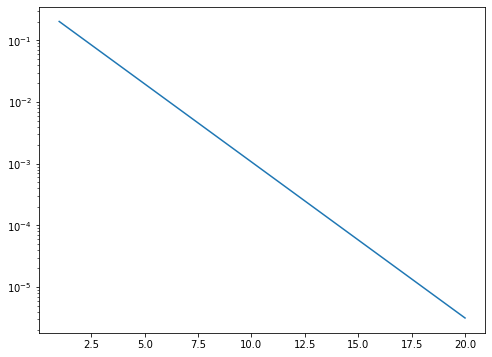

In [15]:
def null_space(A, rcond=None):
    u, s, vh = svd(A, full_matrices=True)
    M, N = u.shape[0], vh.shape[1]
    if rcond is None:
        rcond = np.finfo(s.dtype).eps * max(M, N)
    tol = np.amax(s) * rcond
    num = np.sum(s > tol, dtype=int)
    Q = vh[num:,:].T.conj()
    return Q
def altproj(A, B, v0, n):
    """
    Arguments:
        A {numpy.ndarray} -- matrix whose columns form basis for subspace U
        B {numpy.ndarray} -- matrix whose columns form baiss for subspace W
        v0 {numpy.ndarray} -- initialization vector
        n {int} -- number of sweeps for alternating projection
    Returns:
        v {numpy.ndarray} -- the output after 2n steps of alternating projection
        err {numpy.ndarray} -- the error after each full pass
    """
    
    ### Add code here

    PU = np.dot(A,np.dot((np.linalg.inv((A.T).dot(A))),A.T))
    PW = np.dot(B,np.dot((np.linalg.inv((B.T).dot(B))),B.T))
    basis_UintW = np.concatenate((A, B),axis=1) @ null_space(np.concatenate((A, -B),axis=1))
    P_UintW = np.dot(basis_UintW,np.dot((np.linalg.inv((basis_UintW.T).dot(basis_UintW))),basis_UintW.T))
    vs = np.matmul(P_UintW, v0)
    v= v0
    err=np.zeros(n)
    for t in tqdm(range(2*n), total=2*n, leave=False):
        if(t)%2==0:
            v=np.dot(PU,v)
        else:
            v=np.dot(PW,v)
        if(t+1)%2==0:
            err[t // 2] = np.amax(abs(v - vs))
    return v, err
A = np.array([[3, 1, 4, 1, 5], [2, 5, 11, 17, 23], [3, 7, 13, 19, 29]]).T
B = np.array([[1, 2, 2, 2, 6], [1, 0, 1, 0, -3], [2.5, 6, 12, 18, 26]]).T
v0 = np.array([1, 2, 3, 4, 5])
n = 20
v, err = altproj(A, B, v0, n)
print("altproj Example 1 err:\n",err)
print("altproj Example 1:v\n",v,"\n")

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, n + 1), err)

### Exercise 2
(10 pts program + 5 pts solution)
Write a function `kaczmarz(A,b,I)` that returns a matrix $X$ with $I$ columns corresponding
to the Kaczmarz iteration after $i = 1, 2, ..., I$ full passes through the Kaczmarz algorithm
for the matrix $A$ and right-hand side $\underline{b}$ (e.g., one full pass equals $m$ steps). 
Use this function to find the minimum-norm solution of linear system $A \underline{x} = \underline{b}$ for
$$
A = 
\begin{bmatrix}
 2 & 5 & 11 & 17 & 23 \\ 3 & 7 & 13 & 19 & 29
\end{bmatrix}, \qquad
\underline{b} =
\begin{bmatrix}
 228 \\ 227
\end{bmatrix}
$$
Plot the error (on a log scale) versus the number of full passes for $I = 500$.

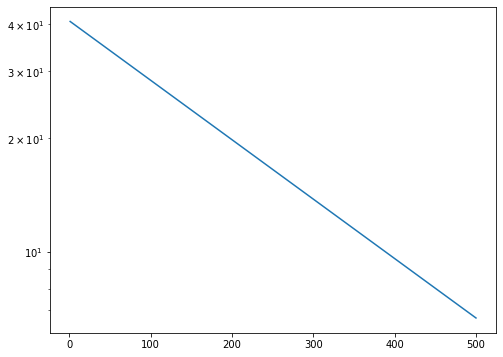

In [19]:
def kaczmarz(A, b, I):
    """
    Arguments:
        A {numpy.ndarray} -- matrix defines the LHS of linear equation
        b {numpy.ndarray} -- vector defines the RHS of linear equation
        I {int} -- number of full passes through the Kaczmarz algorithm
    Returns:
        X {numpy.ndarray} -- the output of all I full passes
        err {numpy.ndarray} -- the error after each full pass
    """
    
    ### Add code here
    m,n=A.shape
    v= np.zeros(n) 
    X=np.zeros((n, I))
    err=np.zeros(I)
    vs=np.dot(np.dot(A.T,(np.linalg.inv(A.dot(A.T)))),b)
    for i in tqdm(range(I*m), total=I*m, leave=False):   
        ai = A[i%m]
        bi = b[i%m]
        #v = v - (np.sum(np.multiply(v,ai)) - bi)/np.sum(np.square(ai))*ai
        v = v-np.dot(ai,(np.dot(v,ai)-bi)/(np.dot(ai,ai)))
        if(i+1)%m==0:
            #err[i // m] =np.sum(np.square(v-v_star))
            err[i // m] = np.amax(abs(np.dot(A,v)-b))
            #err[i // m] = np.amax(abs(np.dot(A,v)-b))
            X[:,i // m] = v.T
    return X, err
A = np.array([[2, 5, 11, 17, 23], [3, 7, 13, 19, 29]])
b = np.array([228, 227])
I = 500
X, err = kaczmarz(A, b, I)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

### Exercise 3
(10 pts)
Repeat the experiment with $I = 100$ for a random system defined by `A = randn(500,1000)`
and `b = A @ randn(1000)`. 
Compare the iterative solution with the true minimum-norm solution 
$ \hat{\underline{x}} = A^H {(A A^H)}^{-1} \underline{b} $.

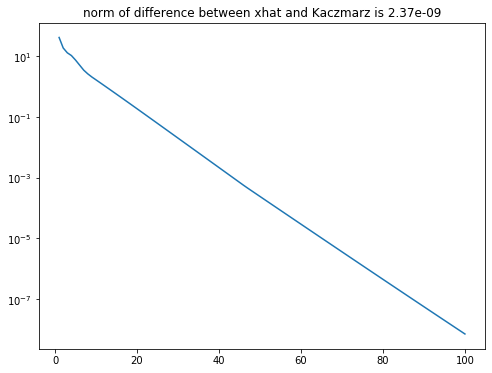

In [21]:
A = randn(500, 1000)
b = A @ randn(1000)
I = 100
X, err = kaczmarz(A, b, I)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

x_hat = np.dot(np.dot(A.T,np.linalg.inv(np.dot(A,A.T))),b)
### x_hat_err = 

plt.title(f'norm of difference between xhat and Kaczmarz is {np.linalg.norm(x_hat - X[:, -1]):.2e}');

### Exercise 4
(10 pts program + 5 pts solution)
Consider the linear program
$$
\min ~ \underline{c}^T \underline{x}
\quad \textrm{subject to} \quad
A \underline{x} \ge \underline{b}, \quad \underline{x} \ge 0
$$
with
$$
\underline{c} = 
\begin{bmatrix}
    3 \\ -1 \\ 2
\end{bmatrix}, \quad
A = 
\begin{bmatrix}
    2 & -1 & 1 \\ 1 & 0 & 2 \\ -7 & 4 & -6
\end{bmatrix}, \quad
\underline{b} = 
\begin{bmatrix}
    -1 \\ 2 \\ 1
\end{bmatrix}, \quad
$$
Let $p^*$ denote the optimum value of this program.
Then, $p^* \le 0$ is satisfied if and only if there is a non-negative $\underline{x} = (x_1, x_2, x_3)^T$ satisfying
$$
\begin{align}
2x_1 - x_2 + x_3 &\ge -1 \\
x_1 + 2x_3 &\ge 2 \\
-7x_1 + 4x_2 - 6x_3 &\ge 1 \\
-3x_1 + x_2 - 2x_3 &\ge 0
\end{align}
$$
where the last inequality restricts the value of the program to be at most $0$.
One can find the optimum value `p` and an optimizer `x` with the command 
```
res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] * c.size, method=’interior-point’)
x, p = res.x, res.fun
```

Starting from $\underline{x}_0 = 0$, write a program that uses alternating projections onto half spaces (see (6)) to find a non-negative vector satisfying the above inequalities. 

Warning: don’t forget to also project onto the half spaces defined by the non-negativity constraints $ x_1 \ge 0, x_2 \ge 0, x_3 \ge 0 $. 

Use the result to find a vector that satisfies all the inequalities. 
How many iterations are required so that the
absolute error is at most 0.0001 in each coordinate?

     con: array([], dtype=float64)
     fun: 1.8272050539280826e-12
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([8.82960371e-13, 3.84137167e-13, 1.00000000e+00])
  status: 0
 success: True
       x: array([1.50428214e-12, 2.00000000e+00, 1.00000000e+00])


False False


array([0., 2., 1.])

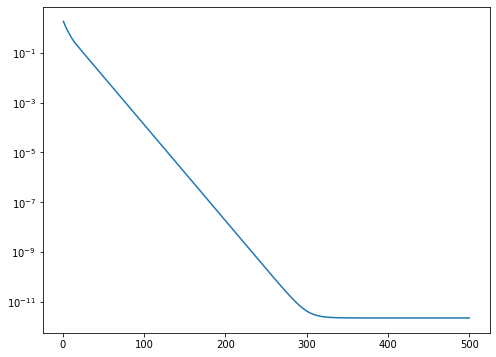

In [22]:
def lp_altproj(A, b, I, res, s=1):
    """
    Find a feasible solution for A v >= b using alternating projection
    with every entry of v0 obeying Uniform[0,1]
    Arguments:
        A {numpy.ndarray} -- matrix defines the LHS of linear equation
        b {numpy.ndarray} -- vector defines the RHS of linear equation
        I {int} -- number of full passes through the alternating projection
        s {numpy.float} -- step size of projection (defaults to 1)
    Returns:
        v {numpy.ndarray} -- the output after I full passes
        err {numpy.ndarray} -- the error after each full pass
    """
    
    # Add code here
    m, n= A.shape
    v=np.zeros(n)
    err=np.zeros(I)
    for t in tqdm(range(I * m), total=I*m, leave=False):
        ai = A[t%m]
        bi = b[t%m]
        if (np.dot(v,ai)<bi):
            v=v-np.dot(ai,(v.dot(ai)-bi)/(ai.dot(ai)))
        if (t + 1) % m == 0:
            #err[t // m] = np.linalg.norm(res-v)
            err[t // m] = np.amax(abs(res-v))
    return v, err
c = np.array([3, -1, 2])
A = np.array([[2, -1, 1], [1, 0, 2], [-7, 4, -6]])
b = np.array([-1, 2, 1])

res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] * c.size, method='interior-point')
print(res)

I = 500
# Do not forget constraint xi >= 0
A1 = np.array([[2, -1, 1], [1, 0, 2], [-7, 4, -6],[-3,1,-2],[1,0,0],[0,1,0],[0,0,1]])
b1 = np.array([-1,2,1,0,0,0,0])

x, err = lp_altproj(A1, b1 , I, res.x, s=1)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

print(np.all(A @ x - b > 0), np.all(x > 0))
x

### Exercise 5
(10 pts + 5 pts for value and strict feasibililty point)
Consider the “random” convex optimization problem defined by
```
c = randn(1000)
A = np.vstack([-np.ones((1, 1000)), randn(500, 1000)])
b = np.concatenate([[-1000], A[1:] @ rand(1000)])
```
Modify $A$ and $b$ (by adding one row and one element) so that your function can be used to prove that the value of the convex optimization problem, in (3), is at most −1000. Try using `I = 1000` passes
through all 501 inequality constraints.
This type of iteration typically terminates with an “almost feasible” $\underline{x}$. 
To find a strictly feasible point, try running the same algorithm with the argument $ \underline{b} + \epsilon $ for some small $ \epsilon > 0 $  (e.g., try $ \epsilon = {10}^{-6} $).
Then, the resulting $ \underline{x} $ can satisfy `np.all(A @ x - b > 0)`

In [ ]:
np.random.seed(0)
c = randn(1000)
A = np.vstack([-np.ones((1, 1000)), randn(500, 1000)])
b = np.concatenate([[-1000], A[1:] @ rand(1000)])
res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] *c.size, method='interior-point')
I, ep = 1000, 1e-6
# Do not forget constraint xi >= 0, and c^T x <= -1000
A1 = np.vstack([A,-c,np.identity(1000)])
b1 = np.concatenate([b,[1000],np.zeros(1000)])

x, err = lp_altproj(A1, b1 + ep, I, res.x)
print(np.all(A @ x - b > 0), np.all(x > 0), c.reshape(1, -1) @ x)

plt.figure(figsize=(8, 6))
plt.semilogy(np.arange(1, I + 1), err)

res = linprog(c, A_ub=-A, b_ub=-b, bounds=[(0, None)] * c.size, method='interior-point')
print(res.fun)

### Exercise 6
(10 pts) Repeat the MNIST training exercise from the Least-Squares Handout using the training method described above. 
First, extract the indices of all the 2’s and randomly separate the samples into equal-sized training and testing groups. 
Second, do the same for the 3’s. Now, extend each vector to length 785 by appending a −1. This will allow the system to learn a general hyperplane separation.

Next, use alternating projections to design a linear classifier to separate for 2’s and 3’s. For the resulting linear function, report the classification error rate and confusion matrices for the both the training and test sets. Is there any benefit to choosing $s<1$? Also, for the test set, compute the histogram of the function output separately for each class and then plot the two histograms together. 
This shows easy or hard it is to separate the two classes.

Depending on your randomized separation into training and test sets, the training data may or may not be linearly separable. 
Comment on what happens to the test set performance when the error rate does converge to zero for the training set.

In [ ]:
# read mnist csv file to a dataframe
df = pd.read_csv('mnist_train.csv')
# append feature column by merging all pixel columns
df['feature'] = df.apply(lambda row: row.values[1:], axis=1)
# only keep feature and label column
df = df[['feature', 'label']]
# display first 5 rows of the dataframe
df.head()

# Pairwise experiment for LSQ to classify between 0 and 1
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
def extract_and_split(df, d, test_size=0.5):
    """
    extract the samples with given labels and randomly separate the samples into training and testing groups, extend each vector to length 785 by appending a −1
    Arguments:
        df {dataframe} -- the dataframe of MNIST dataset
        d {int} -- digit needs to be extracted, can be 0, 1, ..., 9
        test_size {float} -- the fraction of testing set, default value is 0.5
    Returns:
        X_tr {numpy.ndarray} -- training set features, a matrix with 785 columns
                                each row corresponds the feature of a sample
        y_tr {numpy.ndarray} -- training set labels, 1d-array
                                each element corresponds the label of a sample
        X_te {numpy.ndarray} -- testing set features, a matrix with 785 columns 
                                each row corresponds the feature of a sample
        y_te {numpy.ndarray} -- testing set labels, 1d-array
                                each element corresponds the label of a sample

    # Add code here extract data and randomize order
    """
    X=df.loc[df['label']==d,'feature'].values
    y=df.loc[df['label']==d,'label'].values
    
    X_= np.stack(X, axis=0)
    X=np.zeros((len(X_),(X_.shape[1]+1)))
    for i in range(len(X_)):
        for j in range(X_.shape[1]):
            X[i,j]=X_[i][j]
        X[i,X_.shape[1]]=-1

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5,random_state=0)
    return X_tr, X_te, y_tr, y_te  

# Function to remove outliers before plotting histogram
def remove_outlier(x, thresh=3.5):
    """
    returns points that are not outliers to make histogram prettier
    reference: https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting/11886564
    Arguments:
        x {numpy.ndarray} -- 1d-array, points to be filtered
        thresh {float} -- the modified z-score to use as a threshold. Observations with
                          a modified z-score (based on the median absolute deviation) greater
                          than this value will be classified as outliers.
    Returns:
        x_filtered {numpy.ndarray} -- 1d-array, filtered points after dropping outlier
    """
    if len(x.shape) == 1: x = x[:,None]
    median = np.median(x, axis=0)
    diff = np.sqrt(((x - median)**2).sum(axis=-1))
    modified_z_score = 0.6745 * diff / np.median(diff)
    x_filtered = x[modified_z_score <= thresh]
    return x_filtered

## End of helper functions
# General function to train and test pairwise classifier for MNIST digits for Exercise 3.2
def mnist_pairwise_altproj(df, a, b, test_size=0.5, verbose=False, gd=False):
    """
    Pairwise experiment for applying least-square to classify digit a and digit b
    Arguments:
        df {dataframe} -- the dataframe of MNIST dataset
        a, b {int} -- digits to be classified
        test_size {float} -- the fraction of testing set, default value is 0.5
        verbose {bool} -- whether to print and plot results
    Returns:
        res {numpy.ndarray} -- numpy.array([traing error, testing error])
    """
    # Find all samples labeled with digit a and split into train/test sets
    Xa_tr, Xa_te, ya_tr, ya_te = extract_and_split(df, a)

    # Find all samples labeled with digit b and split into train/test sets
    Xb_tr, Xb_te, yb_tr, yb_te = extract_and_split(df, b)

    # Construct the full training set
    X_tr = np.concatenate((Xa_tr, Xb_tr))
    y_tr = np.concatenate((-np.ones_like(ya_tr), np.ones_like(yb_tr)))
    
    # Construct the full testing set
    X_te = np.concatenate((Xa_te, Xb_te))
    y_te = np.concatenate((-np.ones_like(ya_te), np.ones_like(yb_te)))
    
    # Run least-square on training set
    A_tilde = (X_tr*np.expand_dims(y_tr,axis=1))
    z_hat, err = solver(A_tilde, np.ones(len(y_tr)))

        
    # Compute estimation and misclassification on training set
    y_hat_tr = np.dot(X_tr,z_hat)
    for i in range(len(y_hat_tr)):
        if y_hat_tr[i]>=0:
            y_hat_tr[i]=1
        else:
            y_hat_tr[i]=-1
   
    err_tr =1 - accuracy_score(y_tr, y_hat_tr)
    
    # Compute estimation and misclassification on training set
    y_hat_te = np.dot(X_te,z_hat)
    for i in range(len(y_hat_te)):
        if y_hat_te[i]>=0:
            y_hat_te[i]=1
        else:
            y_hat_te[i]=-1
   
    err_te = 1 - accuracy_score(y_te, y_hat_te)
    
    if verbose:
        print('Pairwise experiment, mapping {0} to -1, mapping {1} to 1'.format(a, b))
        print('training error = {0:.2f}%, testing error = {1:.2f}%'.format(100 * err_tr, 100 * err_te))
        
        # Compute confusion matrix
        cm = np.zeros((2, 2), dtype=np.int64)
        cm[0, 0] = ((y_te == -1) & (y_hat_te == -1)).sum()
        cm[0, 1] = ((y_te == -1) & (y_hat_te == 1)).sum()
        cm[1, 0] = ((y_te == 1) & (y_hat_te == -1)).sum()
        cm[1, 1] = ((y_te == 1) & (y_hat_te == 1)).sum()
        print('Confusion matrix:\n {0}'.format(cm))

        # Compute the histogram of the function output separately for each class 
        # Then plot the two histograms together
        ya_te_hat, yb_te_hat = Xa_te @ z_hat, Xb_te @ z_hat
        output = [remove_outlier(ya_te_hat), remove_outlier(yb_te_hat)]
        plt.figure(figsize=(8, 4))
        plt.hist(output, bins=50)
    
    res = np.array([err_tr, err_te])
    return res

solver = lambda A, b: lp_altproj(A, b + 1e-6, 100,np.zeros(785), 1)
z_hat, res = mnist_pairwise_altproj(df, 0, 1, solver, verbose=True)

### Exercise 7
(10 pts program + 10 pts solution)
Describe how this approach should be extended to multi-class linear classification
(parameterized by $ Z \in \mathbb{R}^{n \times d} $) where the classifier maps a vector $\underline{v}$ to class $j$ if the $j$-th element
of $ Z^T \underline{v} $ is the largest element in the vector. 
Use the implied alternating-projection solution to design a multi-class classifier for MNIST.
Is there any benefit to choosing $s<1$?

In [ ]:

from sklearn.model_selection import train_test_split
def mnist_multiclass_altproj(df, solver, test_size=0.5):

#tr, te = 

# Construct the training set

# Construct the testing set

    X=df ['feature'].values
    y=df ['label'].values
    X_= np.stack(X, axis=0)
    X=np.zeros((len(X_),(X_.shape[1]+1)))
    for i in range(len(X_)):
        for j in range(X_.shape[1]):
            X[i,j]=X_[i][j]
        X[i,X_.shape[1]]=-1

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5)


    
    # Apply one-hot encoding to training labels
    Y = np.zeros((y_tr.shape[0],10))
    for i in range(y_tr.shape[0]):
        for j in range(10):
            if (y_tr[i]==j):
                Y[i,j]=1
    # Run least-square on training set
    for i in range(10):
        if i==0:
            A_tilde = np.multiply(X_tr, Y[:,0][:, np.newaxis])
        else:
            A_tilde = np.concatenate((A_tilde, np.multiply(X_tr, Y[:,i][:, np.newaxis])),axis=1)
    A_new=np.zeros((10*y_tr.shape[0],7850))
    for i in range(10*y_tr.shape[0]):
        for j in range((i%10)*785,(i%10)*785+785):
            A_new[i][j]=A_tilde[i//10][j]
            
    
    b_tilde = np.ones(10*y_tr.shape[0])
        
    Z, err = solver(A_new, b_tilde)
    Z = (Z.reshape((10,785))).T

    # Compute estimation and misclassification on training set
    y_hat_tr = np.dot(X_tr,Z).argmax(axis=1)

    err_tr = 1 - np.mean(y_tr == y_hat_tr)    


    # Compute estimation and misclassification on training set
    y_hat_te = np.dot(X_te,Z).argmax(axis=1)

    err_te = 1 - np.mean(y_te == y_hat_te)
    print('training error = {0:.2f}%, testing error = {1:.2f}%'.format(100 * err_tr, 100 * err_te))
    # Compute confusion matrix
    cm = np.zeros((10, 10), dtype=np.int64)
    for a in range(10):
        for b in range(10):
            cm[a, b] = ((y_te == a) & (y_hat_te == b)).sum()
    print('Confusion matrix:\n {0}'.format(cm))
    return Z, res

solver = lambda A, b: lp_altproj(A, b + 1e-6, 100, np.zeros(7850))
Z, res = mnist_multiclass_altproj(df, solver)

### Exercise 8
(optional)
Let $ V = \mathbb{R}^2 $ and consider the orthogonal projection of $ \underline{u} = (1, -2) $ onto the intersection of
$$
\begin{align}
    C_1 &= \left\{ \underline{v} \in V \,\mid\, v_2 \ge 0 \right\} \\
    C_2 &= \left\{ \underline{v} \in V \,\mid\, v_1^2 + \left(v_2 - \frac{\sqrt{3}}{2}\right)^2 \le 1 \right\}
\end{align}
$$
Draw a picture illustrating the algernating projections (without Dykstra's modification) defined by: $ P_{C_2}(P_{C_1}(\underline{u})) $ and $ P_{C_1}(P_{C_2}(\underline{u})) $.
Does either give the desired result $ P_{C_1 \cap C_2}(\underline{u}) $?
Now, try Dykstra's algorithm using both orders and 4 iterations.
Are these approaching $ P_{C_1 \cap C_2}(\underline{u}) $?

In [23]:
import numpy as np
import pandas as pd
#from altproj_code import altproj, kaczmarz, lp_altproj

#
# Desired output of this script
# -----------------------------
#
# altproj Example 1 err:
#  [1.0752     0.99090432 0.91321742 0.84162118 0.77563808]
# altproj Example 1:v
#  [0.58172856 0.77563808] 
#
# altproj Example 2 err:
#  3.3587408979332825
# altproj Example 2 v:
#  [5.80196883 5.7414081  5.80196883 4.7037591  5.80196883] 
#
# altproj Example 3 err:
#  0.020871922644255747
# altproj Example 3 v:
#  [2.70685396 5.37727694 2.70685396 8.04162808 2.70685396] 
#
# kaczmarz Example 4 err:
#  0.028524403942799426
# kaczmarz Example 4 X:
#  [-0.13512375  0.0941078  -0.13512375  0.39621042 -0.13512375] 
#
# kaczmarz Example 5 err:
#  0.01468037281401613
# kaczmarz Example 5 X:
#  [-0.03184633 -0.03805198  0.04546457  0.02235128  0.04669109  0.108116  ] 
#
#

### If you project on x >= 0 constraints only after each full pass
# lp_altproj Example 6 err:
#  0.05188146770730828
# lp_altproj Example 6 v:
#  [-1.96541235 -1.98270618] 
#
# lp_altproj Example 7 err:
#  0.7250551085496868
# lp_altproj Example 7 v:
#  [2.01660003 1.81980856 1.62730644] 

### If you project on x >= 0 constraints after each row of A
# lp_altproj Example 6 err:
#  3.333333318673178
# lp_altproj Example 6 v:
#  [0.66666666 0.        ] 
#
# lp_altproj Example 7 err:
#  0.6566929819164207
# lp_altproj Example 7 v:
#  [2.02850424 1.83679799 1.64897667] 


# Test altproj
A = np.array([[4, 3]]).T
B = np.array([[3, 4]]).T
v0 = np.array([1, 1])
n = 5
v, err = altproj(A, B, v0, n)
print("altproj Example 1 err:\n",err)
print("altproj Example 1:v\n",v,"\n")

A = np.array([[1, 2, 1, 3, 1],[6, 7, 6, 7, 6]]).T
B = np.array([[1, 2, 1, 3, 1],[7, 8, 7, 8, 7]]).T
v0 = np.array([10, 2, 10, 3, 10])
n = 5000
v, err = altproj(A, B, v0, n)
print("altproj Example 2 err:\n",err[-1])
print("altproj Example 2 v:\n",v,"\n")
n = 40000
v, err = altproj(A, B, v0, n)
print("altproj Example 3 err:\n",err[-1])
print("altproj Example 3 v:\n",v,"\n")

# Test kaczmarz
A = np.array([[1, 2, 1, 3, 1],[6, 7, 6, 7, 6]])
b = np.array([1, 1])
X, err = kaczmarz(A, b, 20)
print("kaczmarz Example 4 err:\n",err[-1])
print("kaczmarz Example 4 X:\n",X[:,-1],"\n")

A = np.array([[4, 2, 7, 3, 1, 7],[6, 7, 6, 7, 6, 7],[1, 2, 3, 4, 5, 6]])
b = np.array([1, 1, 1])
X, err = kaczmarz(A, b, 20)
print("kaczmarz Example 5 err:\n",err[-1])
print("kaczmarz Example 5 X:\n",X[:,-1],"\n")

# Test lp_altproj
A = np.array([[-2, 1],[1, -2]])
b = np.array([2,2])
v, err = lp_altproj(A, b, 10)
print("lp_altproj Example 6 err:\n",err[-1])
print("lp_altproj Example 6 v:\n",v,"\n")

A = np.array([[-4, 3,3],[3, -4, 3],[3, 3, -4]])
b = np.array([3,4,5])
v, err = lp_altproj(A, b, 10)
print("lp_altproj Example 7 err:\n",err[-1])
print("lp_altproj Example 7 v:\n",v,"\n")

altproj Example 1 err:
 [1.0752     0.99090432 0.91321742 0.84162118 0.77563808]
altproj Example 1:v
 [0.58172856 0.77563808] 



altproj Example 2 err:
 3.3587408979185076
altproj Example 2 v:
 [5.80196883 5.7414081  5.80196883 4.7037591  5.80196883] 



altproj Example 3 err:
 0.02087192261589621
altproj Example 3 v:
 [2.70685396 5.37727694 2.70685396 8.04162808 2.70685396] 



kaczmarz Example 4 err:
 0.028524403942799426
kaczmarz Example 4 X:
 [-0.13512375  0.0941078  -0.13512375  0.39621042 -0.13512375] 



kaczmarz Example 5 err:
 0.01468037281401613
kaczmarz Example 5 X:
 [-0.03184633 -0.03805198  0.04546457  0.02235128  0.04669109  0.108116  ] 



TypeError: lp_altproj() missing 1 required positional argument: 'res'